<a href="https://colab.research.google.com/github/JECaballeroR/EmployeeTurnover/blob/main/Clonk_Prueba_selecci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install ppscore

In [2]:
import ppscore as pps
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.pipeline import make_pipeline
from sklearn.model_selection import  GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import (f1_score, roc_auc_score, precision_recall_curve, 
                            roc_curve, confusion_matrix, classification_report, 
                            accuracy_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier

from warnings import filterwarnings

filterwarnings("ignore")


# Preparación de datos
##Carga y exploración básica


Los features del dataset son:
* **satisfaction_level**: Nivel de Satisfacción, de 0 a 1 (Flotante).
* **last_evaluationTime**: Años desde la última evaluación de desempeño (Flotante)
* **number_project**:Cantidad de proyectos terminados durante la vinculación laboral (Entera)
* **average_montly_hours**: Horas promedio mensuales trabajadas (Entera)
* **time_spend_company**: Años de vinculación en la compañía (Entera)
* **Work_accident**: Si el empleado tuvo o no Accidente de trabajo (Binaria)
* **left**: Si el empleado dejo o no el trabajo (Variable Respuesta) (Binaria)
* **promotion_last_5years**: Si el empleado tuvo o no un ascenso en los últimos 5 años (Binaria).
* **sales**: Departamento al que el empleado estuvo vinculado (Categórica).
* **salary**: Nivel relativo del salario (low, medium, high) (Categórica)



Se cargan los datos y se validan ciertos elementos, a saber:

*   Que no haya datos faltantes 
*   Que todos los datos sean coherentes con las variables
*   Que la variable respuesta este balanceada 

Después de estas validaciones iniciales, se modifican los nombres de las variables para su interpretabilidad y se realiza un Análisis de Datos Exploratorio para conocer mejor el dataset.


In [3]:
#Se carga y presentan los datos
df=pd.read_csv("HR_comma_sep.csv")
df

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low


In [4]:
#Verificación de datos nulos en el dataset
df.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

In [5]:
#Para variables categoricas y binarias, verificación de que no hayan elementos mal escritos o similar.
#Para esto, se imprimen los valores únicos de cada variable
variables_bin_cat=[ 'Work_accident', "left", "promotion_last_5years", "sales", "salary"]
[ (i, df[i].unique()) for i in variables_bin_cat]

[('Work_accident', array([0, 1])),
 ('left', array([1, 0])),
 ('promotion_last_5years', array([0, 1])),
 ('sales',
  array(['sales', 'accounting', 'hr', 'technical', 'support', 'management',
         'IT', 'product_mng', 'marketing', 'RandD'], dtype=object)),
 ('salary', array(['low', 'medium', 'high'], dtype=object))]

In [6]:
#Para la verificación de variables númericas continuas, se usa DataFrame.describe() para validar el rango de los datos
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


De este dataframe se puede observar que:
1.   Las evaluaciones de desempeño se realizan juiciosamente de manera anual, dado que el máximo valor es 1 (eso, o quizá son más bien el nivel de desempeño en la última evaluación de desempeño)
2.   Existen empleados que trabajan más de 10 horas al día en promedio (máximo de 310 horas al mes/30 días al mes= 10.33 horas al día). A priori, parece una posible causa de abandono.
3. Se observa que la mayoría de empleados (al menos el 75%) no han abandonado a la compañía, recibido un ascenso en los últimos 5 años o tenido un accidente de trabajo. Esto sugiere que el dataset está no balanceado
4. Igualmente, al menos el 75% de los empleados a trabajado con la compañía menos de 5 años, por lo que el punto 3 parece indicar que no hay muchos ascensos en la companía (otro posible factor de abandono)
5. En general, parece no existir problemas con los datos.




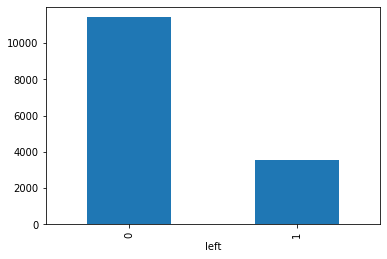

In [7]:
# Se verifica si la variable respuesta se encuentra balanceada en el dataset, mostrando el conteo de la misma
df.groupby("left")['sales'].count().plot(kind='bar')

In [8]:
# Se renombra "sales" como "department", "salary" como "salary_level", "left" como "employee_left"
# Esto es para dar nombres más interpretables de las variables
df=df.rename(columns = {'sales':'department', 'salary': 'salary_level', 'left':'employee_left'})



# Análisis Exploratorio de Datos (EDA)

Se revisará a mayor profundidad los datos para detectar ciertas interacciones y guiar la futura interpretación de los modelos.

Para ello, se revisarán interacciones, agrupaciones y visualizaciones de los datos, y se generarán ideas del algunas interacciones interesantes que se detecten. 

1. Observar si, al agrupar los datos por alguna variable, se observa que alguna otra tiene un nivel diferente (por ejemplo, si se ve un cambio en los niveles de motivación entre los diferentes niveles de salario).
2. Generar algunos heatmaps para apoyar las posibles tendencias que se vean (por ejemplo, detectar los departamentos de mayor rotación de personal)
3. Generar visualizaciones de apoyo para encaminar el primer modelo (elegir features)



In [9]:
df.groupby('employee_left').mean()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years
employee_left,,,,,,,
0,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.026251
1,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,0.005321


In [10]:
df.groupby(['employee_left','salary_level']).mean()

satisfaction_level  ...  promotion_last_5years
employee_left salary_level                      ...                       
0             high                    0.651879  ...               0.062338
              low                     0.668103  ...               0.010109
              medium                  0.668875  ...               0.034315
1             high                    0.434512  ...               0.000000
              low                     0.441248  ...               0.006446
              medium                  0.438550  ...               0.003797

[6 rows x 7 columns]

Se observa que el nivel de satisfacción es mayor para los empleados que se mantienen en la empresa. Los que aun trabajan han tenido más ascensos y accidentes de trabajo.

Los empleados de alto salario que abandonaron la empresa no tuvieron accidentes laborales o ascensos, siendo quizá este último una causa de su deserción.

In [11]:
df.groupby('salary_level').mean()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,employee_left,promotion_last_5years
salary_level,,,,,,,,
high,0.637470,0.704325,3.767179,199.867421,3.692805,0.155214,0.066289,0.058205
low,0.600753,0.717017,3.799891,200.996583,3.438218,0.142154,0.296884,0.009021
medium,0.621817,0.717322,3.813528,201.338349,3.529010,0.145361,0.204313,0.028079


Se observa que el mayor salario parece inducir a menos probablidad de ascensos y a una menor tasa de abandono. Los demas factores lucen relativamente similares.

In [12]:
df.groupby('department').mean()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,employee_left,promotion_last_5years
department,,,,,,,,
IT,0.618142,0.716830,3.816626,202.215974,3.468623,0.133659,0.222494,0.002445
RandD,0.619822,0.712122,3.853875,200.800508,3.367217,0.170267,0.153748,0.034307
accounting,0.582151,0.717718,3.825293,201.162973,3.522816,0.125163,0.265971,0.018253
hr,0.598809,0.708850,3.654939,198.684709,3.355886,0.120433,0.290934,0.020298
management,0.621349,0.724000,3.860317,201.249206,4.303175,0.163492,0.144444,0.109524
marketing,0.618601,0.715886,3.687646,199.385781,3.569930,0.160839,0.236597,0.050117
product_mng,0.619634,0.714756,3.807095,199.965632,3.475610,0.146341,0.219512,0.000000
sales,0.614447,0.709717,3.776329,200.911353,3.534058,0.141787,0.244928,0.024155
support,0.618300,0.723109,3.803948,200.758188,3.393001,0.154778,0.248991,0.008973


Parece ser que el departamento en que un empleado trabaja afecta principalmente sus posibilidades de ascenso. La tasa de salida varía por deparamento también, pero en una menor medida comparado con el ascenso en los últimos 5 años.


In [13]:
df.groupby('number_project').mean()

,satisfaction_level,last_evaluation,average_montly_hours,time_spend_company,Work_accident,employee_left,promotion_last_5years
number_project,,,,,,,
2,0.478769,0.568505,160.342546,3.180486,0.092965,0.656198,0.015494
3,0.687670,0.716572,197.507522,3.286560,0.175092,0.017756,0.023428
4,0.695132,0.740009,205.122108,3.454983,0.156472,0.093700,0.026804
5,0.678888,0.762010,212.061572,3.800072,0.150670,0.221659,0.018109
6,0.273458,0.786550,238.694208,4.192504,0.114140,0.557922,0.017036
7,0.118711,0.859609,276.078125,4.113281,0.015625,1.000000,0.000000


Podría decirse que los proyectos ejecutados podrían mostrar la responsabilidad asignada en la organización. Debe haber un equilibrio: Ni tan poca responsabilidad que parezca que la organización no confía en el empleado, ni tanta que parezca que el empleado es un solo departamento.

Es interesante que aquellos empleados con el mínimo y máximo número de proyectos asignados son los empleados más propensos a abandonar la organización.

Igualmente, los empleados con el mayor número de proyectos realizados no han tenido un ascenso en los últimos 5 años. "Mucha carga, poca recomensa" puede ser un motivo de abandono en esta organización.

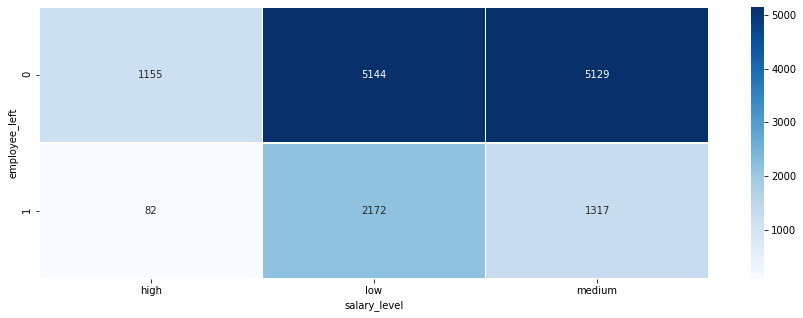

In [14]:

def heatmap_count(df, var1, var2):
  """Generates a Count heatmap of any two columns of a data frame

  Parameters
  ----------
  df : DataFrame
      A DataFrame that has column features
  var1 : str
      The name of a column in the DataFrame
  var2 : str
      The name of a column in the DataFrame. Different from var1
  
  Returns
  -------
  plot : seaborn.heatmap
      A heatmap of the 2 variables grouped by count, with preset configuration
  """

  heat_df=[]
  heat_df=pd.DataFrame(df.groupby([var1,var2]).count().iloc[:,1]).reset_index()
  cols=heat_df.columns
  value=[y for y in cols if y not in [var1, var2]]
  heat_df=heat_df.pivot(columns=var1, index=var2, values=value[0])
  plt.figure(figsize=(15,5))
  return sns.heatmap(heat_df, cmap="Blues",linewidths=0.5, annot=True, fmt='g')

  
heatmap_count(df, "salary_level", "employee_left")

Se observa que el alto salario parece "prevenir" el abandono en la empresa, dado que al incrementar el nivel de salario, existe un menor porcentaje de personas que abandonan la empresa.

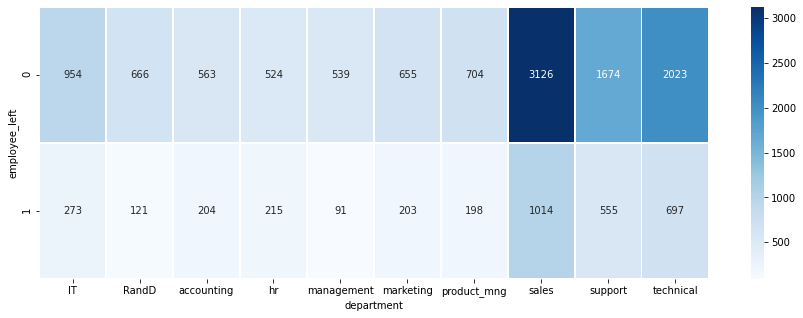

In [15]:
heatmap_count(df, "department", "employee_left")

Se logra ver que los departamentos de Sales, support y technical poseen mayor munero de empleados. Además, se ve que existen departamentos como management que tienen una menor tasa de salida (salen 91 de 539+91, vs digamos, en sales que salen 1014 de 1014+3126- que es casi un tercio-)

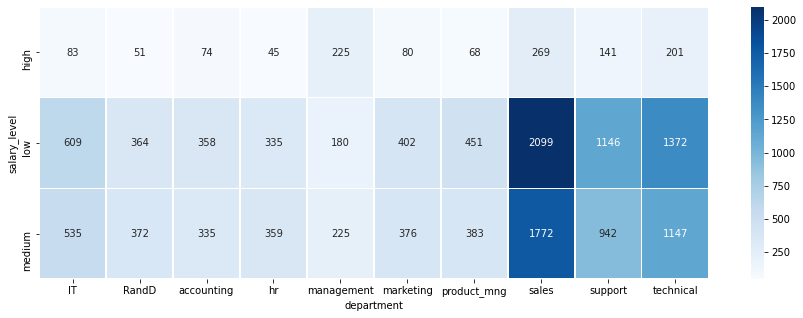

In [16]:
heatmap_count(df, "department", "salary_level")

Los niveles de salario Low y Medium tienen un comportamiento similar entre los departamentos.  Los departamentos Sales, technical y Management son departamentos que presentan un número relativamente mayor de personas de mayor salario.

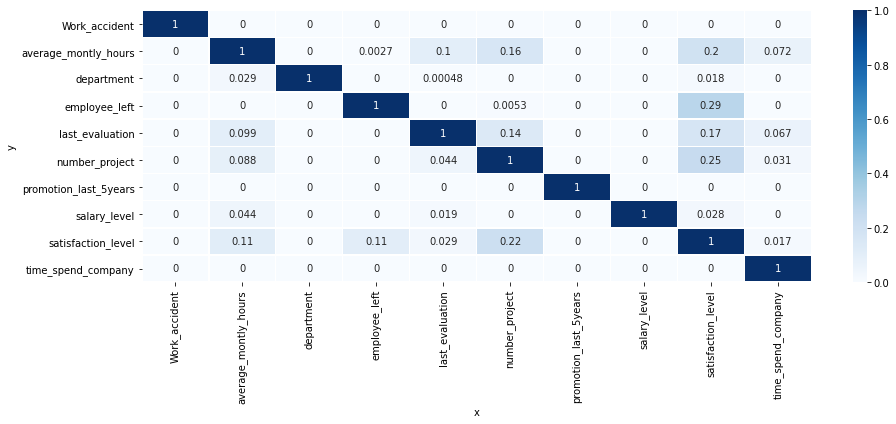

In [17]:
#Se realiza un mapa de calor de Predictive Power Score (PPS).
#El PPS es una métrica que mide el poder predictivo de una variable sobre otra.
#Esta se utiliza para observar correlaciones y posibles variables de interés para los modelos
matrix_df = pps.matrix(df)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
plt.figure(figsize=(15,5))
sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)

El Predictive Power Score es una medida del poder predictivo de una variable. 

Esta gráfica nos muestra que la variable "employee_left" puede ser predecia por las variables "number_projects", y "satisfaction_level", pues la fila de "employee_left" posee valores en estas columnas.

Esta gráfica parece apoyar algunas de las hipótesis que se han ido formando:
1. El número de proyectos si tiene poder predictivo sobre la satisfacción del empleado.
2. La variable que mayor poder predictivo tiene es la satisfacción del empleado.
3. Es posible que los Features más relevantes sean satisfaction_level,number_project, average_monthy_hours, time_spend_company y last_evaluation. Esto son, qeullos features que directamente tienen poder predictivo sobre la variables respuesta; y los features que tienen poder predictivo sobre aquellos que predicen la variable respuesta.

# Modelado preliminar
## Preparación de los datos
Se aplica cambios a los datos originales, haciendo las variables departmetn y salary_level categóricas.

Se probarán inicialmente los modelos:

* Regresión Logística
* Random Forest (Clasificador)
* KNN (Clasificador)
* Red Neuronal para clasificación binaría

Para las pruebas iniciales, se hará un split 80-20 para Entrenamiento y Prueba, se tomarán más muestras de la clase minoritaria (upsampling) para manejar la clase no balanceada y se tomará la versión "por defecto" de los modelos en sklearn con todos los features del set de datos. 

Para comparar los modelos, se usarán la curva ROC-AUC y los datos de la matriz de confusión. Esto es puesto que, al no estar balanceados los datos de las variables respuesta, el acuraccy no es una medida idónea para comparación de modelos.

El objetivo de este paso es la generación de un insight inicial de que tan buenos predictores para el set de datos son cada uno de los modelos.


Posteriormente, se hará un tuneo de los hiper parámetros de cada modelo. En este paso, se compará la mejor versión encontrada de cada modelo entre si, y se elegirá aquel que posea una mejor ROC-AUC y Matriz de confusión.



In [18]:
df=df.astype({"department":"category", "salary_level":"category"})
df.dtypes

satisfaction_level        float64
last_evaluation           float64
number_project              int64
average_montly_hours        int64
time_spend_company          int64
Work_accident               int64
employee_left               int64
promotion_last_5years       int64
department               category
salary_level             category
dtype: object

In [314]:
def get_X_y(df, y_name):
  """
  Splits a DataFrame in X (Features) and y (response variable)
  Parameters
  ----------
  df : DataFrame
      A DataFrame that has column features.
  y_name : str
      The name of the target varriable in the DataFrame.

  
  Returns
  -------
  X : DataFrame
      DataFrame with the features used to predict y.
  y : Array(int)
      Array with the response variable's values.
  """
  y=[y_name]
  X=[col for col in df.columns if col not in y]
  y=df[y].copy().values.flatten()
  X=pd.get_dummies(df[X].copy())
  return X, y


def data_preprocessing_up_or_down_sample(X, y, sample="up", test_size=0.2):
  """
  Applies downsampling or upsampling, and returns the Train-Test split 
  of data.
  Parameters
  ----------
  X : DataFrame
      DataFrame with the features used to predict y.
  y : Array(int)
      Array with the response variable's values.
  sample : str(optional)
      Chooses the method to apply. Downsampling ("down"), 
      upsampling ("up") or no method (anything else). Default is "up". 
  test_size : float(optional)
      Sets the test_size parameter of sklearn.model_selection.train_test_split.
      Default is 0.2
  
  Returns
  -------
  splitting : list, length=2 * len(arrays)
      List containing train-test split of inputs, with the method defined by
      the parameter sample applied.
  """

  # Use the sample parameter to define local variables to select the correct 
  # method
  a,b=0,0
  if sample=="up": 
    a,b=1,0
  if sample=="down":
    a,b=0,1 

  
  # Apply the normal train_test_split to the data
  X_train, X_test, y_train, y_test = train_test_split( X, y, \
                                        test_size=test_size)
  # Using the a and b local variables, apply downsampling or upsampling only
  # if the sample parameter is "up" or "down".

  if a+b>=1:
    X_train_temp, y_train_temp = resample(X_train[y_train == a],
                                    y_train[y_train == a],
                                    n_samples=X_train[y_train == b].shape[0])
    X_train = np.concatenate((X_train[y_train == b], X_train_temp))
    y_train = np.concatenate((y_train[y_train == b], y_train_temp))
  return (X_train, X_test, y_train, y_test)


def rocauc_plot(model, model_name, y_test, X_test):
  """
  Plots the ROC-AUC curve for a model. 
  Multiple consecutive calls will allow to display multiple curves on the
  same plot

  Parameters
  ----------
  model : estimator object.
      Either from sklearn or keras interfaces
  model_name : str
      Name of the plot
  X_test : {array-like, sparse matrix} of shape (n_samples, n_features)
      Input values
  y_test : {array-like, sparse matrix} of shape (n_samples, n_features)
      Target values
  test_size : float(optional)
      Sets the test_size parameter of sklearn.model_selection.train_test_split.
      Default is 0.2
  
  Returns
  -------
  plot : matplotlib.pyplot
      Plot of the ROC-AUC score
  """
  try:
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
  except:
    auc = roc_auc_score(y_test, model.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test))
  plt.plot(fpr, tpr, label=model_name+" AUC = {:.5f}".format(auc))
  plt.title("Curva(s) ROC", fontdict={"fontsize": 21})
  plt.xlabel("False positive rate", fontdict={"fontsize": 13})
  plt.ylabel("True positive rate", fontdict={"fontsize": 13})
  plt.legend(loc="lower right")
  plt.plot([0, 1], [0, 1], "r--")



def plot_roc_conf_matrix(y_test,X_test, model, model_name):
  """
  Print the classification report and plots the ROC-AUC curve and confusion 
  matrix for a given model.

  Arguments
  ---------
  y_test : {array-like, sparse matrix} of shape (n_samples, n_features)
      Target values
  X_test : {array-like, sparse matrix} of shape (n_samples, n_features)
      Input values
  model : estimator object.
      Either from sklearn or keras interfaces
  model_name : str
      Name of the model. Used as part of the plot's titles.
  
  """
  try:
    y_pred=model.predict_classes(X_test)
  except:
    y_pred=model.predict(X_test)
  cm = metrics.confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(15,5))
  plt.subplot(1,2,1)
  sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
  plt.title(model_name+ " - Matriz de confusión", y=1.1, \
            fontdict={"fontsize": 21})
  plt.xlabel("Predicted", fontdict={"fontsize": 14})
  plt.ylabel("Actual", fontdict={"fontsize": 14})
 
  print(classification_report(y_test, y_pred))
  plt.subplot(1,2,2)

  rocauc_plot(model, model_name, y_test, X_test)


def apply_model_to_df(data, model, model_name):
  """
  Applies a sklearn estimator to a DataFrame. 
  It returns a fitted model and shows relevant information of the model's
  performance (applies the plot_roc_conf_matrix function to it)

  Parameters
  ----------
  data : List of Arrays
      List of arrays, equivalent to the output of the function
      sklearn.model_selection.train_test_split  
  model : estimator object.
      Either from sklearn or keras interfaces
  model_name : str
      Name of the model. Used as part of the plot's titles.
  
  Returns
  -------
  model : estimator instance
      Fitted classifier or a fitted Pipeline in which the last estimator 
      is a classifier.
  """
  X_train, X_test, y_train, y_test=data
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  plot_roc_conf_matrix(y_test,X_test, model, model_name)
  return model

In [320]:
nn.predict_proba(X_test)

array([[0.8689878 ],
       [0.1676667 ],
       [0.90926147],
       ...,
       [0.00184131],
       [0.9460629 ],
       [0.58358693]], dtype=float32)

In [20]:
X,y=get_X_y(df, "employee_left")
data_up = data_preprocessing_up_or_down_sample(X, y ,"up", test_size=0.2)
data_down = data_preprocessing_up_or_down_sample(X, y ,"down", test_size=0.2)
data_as_is= data_preprocessing_up_or_down_sample(X, y ,"None", test_size=0.2)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2266
           1       0.99      0.97      0.98       734

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



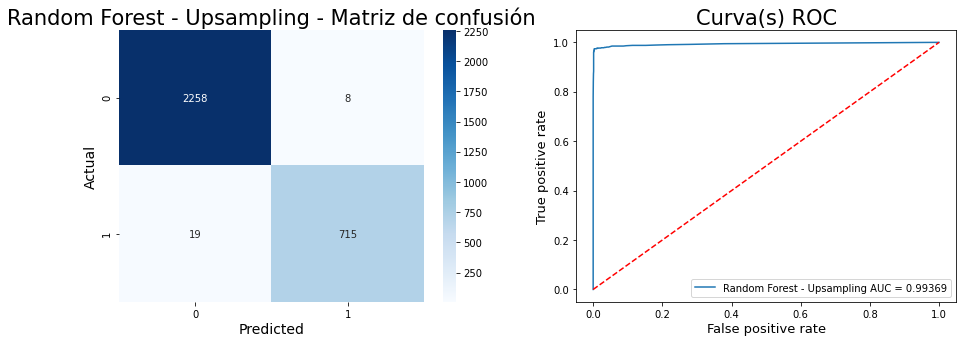

In [21]:
rf_us=apply_model_to_df(data_up,RandomForestClassifier(), "Random Forest - Upsampling")


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2308
           1       0.97      0.97      0.97       692

    accuracy                           0.99      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.99      0.99      0.99      3000



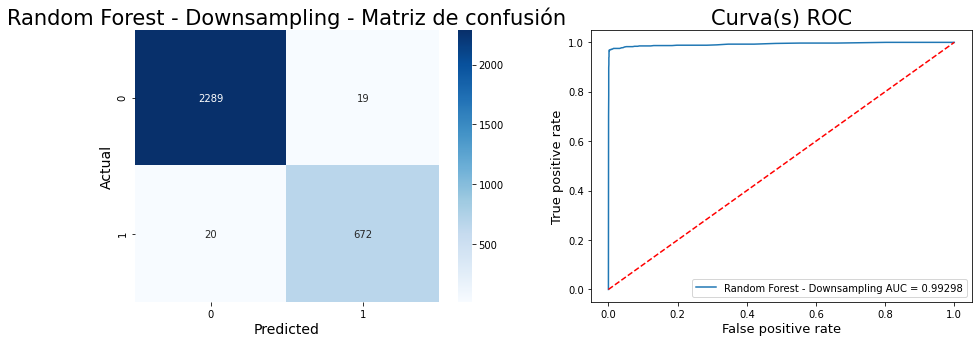

In [22]:
rf_ds=apply_model_to_df(data_down,RandomForestClassifier(),"Random Forest - Downsampling")


              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2283
           1       1.00      0.98      0.99       717

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



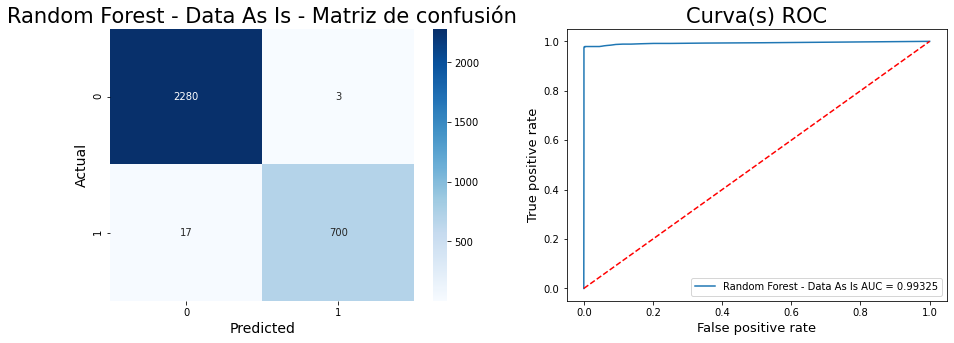

In [23]:
rf_asis=apply_model_to_df(data_as_is,RandomForestClassifier(),"Random Forest - Data As Is")


In [24]:
rf_us.get_params(deep=False)

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

              precision    recall  f1-score   support

           0       0.92      0.75      0.83      2266
           1       0.51      0.81      0.63       734

    accuracy                           0.76      3000
   macro avg       0.72      0.78      0.73      3000
weighted avg       0.82      0.76      0.78      3000



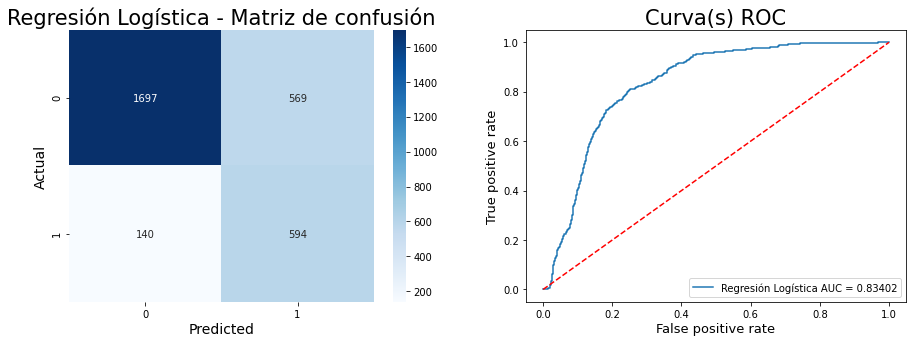

In [25]:
lr_no=apply_model_to_df(data_up,LogisticRegression(class_weight="balanced"), "Regresión Logística")


              precision    recall  f1-score   support

           0       0.99      0.89      0.94      2266
           1       0.75      0.97      0.84       734

    accuracy                           0.91      3000
   macro avg       0.87      0.93      0.89      3000
weighted avg       0.93      0.91      0.92      3000



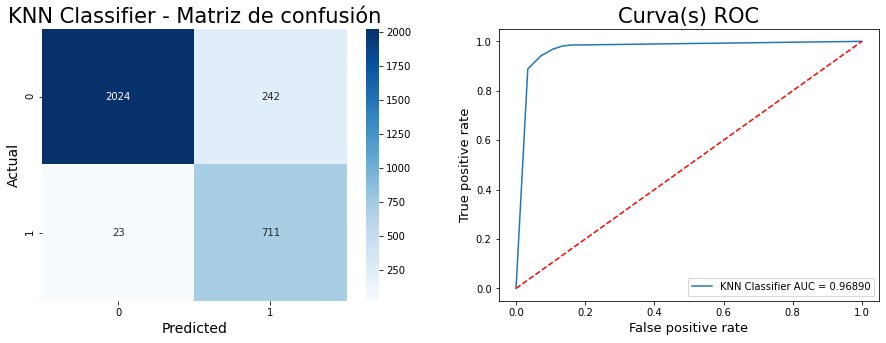

In [26]:
knn_no=apply_model_to_df(data_up,KNeighborsClassifier(), "KNN Classifier")


Epoch 1/10
3665/3665 [==============================] - 5s 1ms/step - loss: 3.3594 - binary_accuracy: 0.5481
Epoch 2/10
3665/3665 [==============================] - 5s 1ms/step - loss: 0.5714 - binary_accuracy: 0.7399
Epoch 3/10
3665/3665 [==============================] - 5s 1ms/step - loss: 0.4603 - binary_accuracy: 0.8114
Epoch 4/10
3665/3665 [==============================] - 5s 1ms/step - loss: 0.4320 - binary_accuracy: 0.8266
Epoch 5/10
3665/3665 [==============================] - 4s 1ms/step - loss: 0.4145 - binary_accuracy: 0.8333
Epoch 6/10
3665/3665 [==============================] - 4s 1ms/step - loss: 0.4166 - binary_accuracy: 0.8322
Epoch 7/10
3665/3665 [==============================] - 4s 1ms/step - loss: 0.4115 - binary_accuracy: 0.8354
Epoch 8/10
3665/3665 [==============================] - 4s 1ms/step - loss: 0.4036 - binary_accuracy: 0.8384
Epoch 9/10
3665/3665 [==============================] - 4s 1ms/step - loss: 0.4045 - binary_accuracy: 0.8398
Epoch 10/10
3665/36

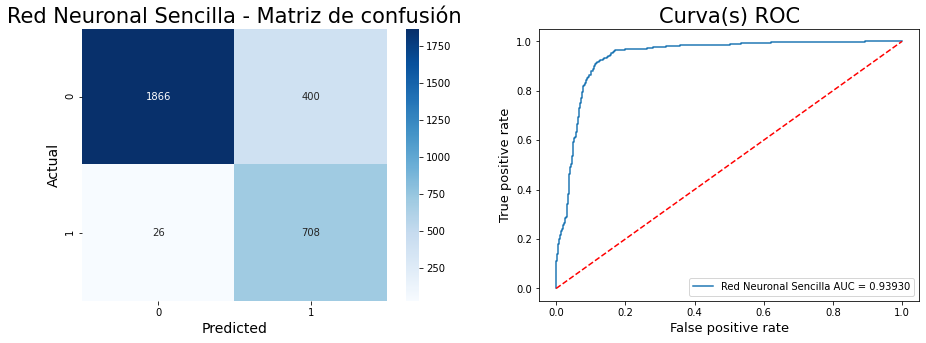

In [27]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
X_train, X_test, y_train, y_test=data_up
nn=Sequential()
nn.add(Dense(20, input_dim=20, activation='relu'))
nn.add(Dropout(0.15))
nn.add(Dense(1, activation='sigmoid'))
nn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['binary_accuracy'])
nn.fit(X_train,y_train,epochs=10,batch_size=5)
plot_roc_conf_matrix(y_test,X_test, nn, "Red Neuronal Sencilla")


IndexError: ignored

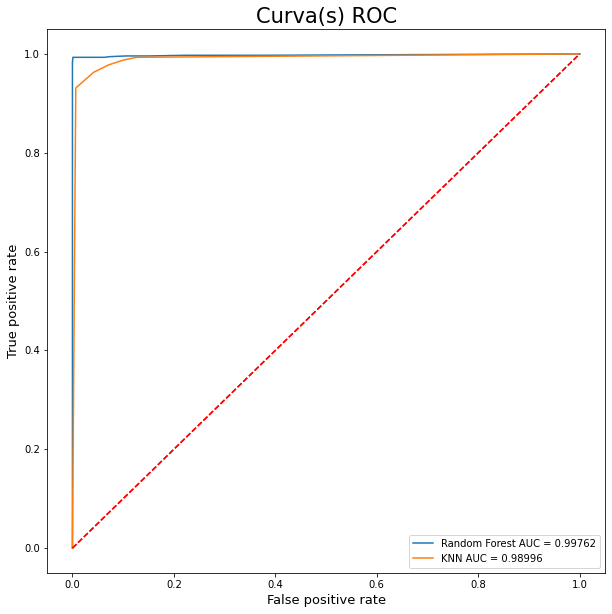

In [313]:
plt.figure(figsize=(10,10))

rocauc_plot(rf_us, "Random Forest", y_test, X_test)
rocauc_plot(knn_no, "KNN", y_test, X_test)
rocauc_plot(nn, "Red Neuronal sencilla", y_test, X_test)

rocauc_plot(lr_no, "Regresión logística", y_test, X_test)

# Tuneo de Hiper Parámetros y selección de mejor modelo

Para esto, se define un pipeline general para todos los modelos: 

1. Se aplica un StandardScaler, esto es, se estandarizan los datos. 
2. Se realiza un Grid Search con Cross Validation, usando:
  1. Una lista de parámetros, con sus posibles valores
  2. 10-fold Cross Validation
  3. Selección del mejor modelo por el f1 score.

La estandarización de datos se realiza para mejorar el desempeño de los modelo. Dada la naturaleza original no balanceada de los datos, se usa el f1 score y la curva ROC-AUC en lugar del Acurracy cómo medida de mejor desempeño.


El mejor modelo entonces se guarda, y se simula su carga y evaluación sobre datos nunca vistos (con los datos de prueba). Adicionalmente, se presenta el gráfico de Feature Importance del modelo seleccionado.

In [29]:
X,y=get_X_y(df, "employee_left")
X_train, X_test, y_train, y_test =data_preprocessing_up_or_down_sample(X, y , "up",test_size=0.2)

In [223]:
def pipeline_classifier(X,y,model, param_grid):
  """
  Creates a general Pipeline for sklearn classifiers.
  Applies GridSearchCV to optimize hyper parameters of the model.

  Parameters
  ----------
  X : {array-like, sparse matrix} of shape (n_samples, n_features)
      Input values
  y : {array-like, sparse matrix} of shape (n_samples)
      Target values
  model : sklearn.estimator object
      Instance of an estimator form sklearn.
  param_grid: dict or list of dictionaries
      Dictionary with parameters names (str) as keys and lists of parameter 
      settings to try as values, or a list of such dictionaries, in which case 
      the grids spanned by each dictionary in the list are explored. 
      This enables searching over any sequence of parameter settings.
    
  Returns
  -------
  model : sklearn.estimator instance
      Fitted classifier or a fitted Pipeline in which the last estimator 
      is a classifier.
  """
  pipe = make_pipeline(StandardScaler(), model)
  clf= GridSearchCV(pipe,
                    param_grid=param_grid,
                    cv=10,
                    refit=True,
                    scoring="f1",
                    n_jobs=-1)
  clf.fit(X,y)
  return clf


In [224]:
rf_param_grid = {
        "randomforestclassifier__min_samples_leaf": [1, 3, 5],
        "randomforestclassifier__n_estimators": [50,100, 250],
        "randomforestclassifier__criterion": ["gini", "entropy"]}
rf_gs=pipeline_classifier(X_train,y_train,
                          RandomForestClassifier(class_weight="balanced")\
                          ,rf_param_grid )

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2275
           1       0.99      0.96      0.98       725

    accuracy                           0.99      3000
   macro avg       0.99      0.98      0.99      3000
weighted avg       0.99      0.99      0.99      3000



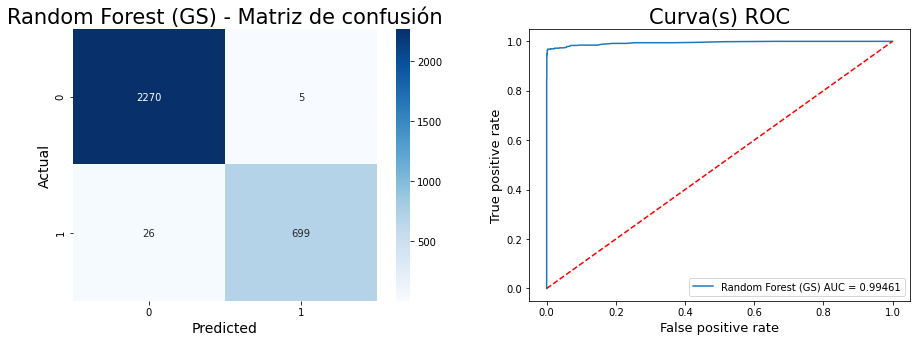

In [225]:
plot_roc_conf_matrix(y_test,X_test, rf_gs, "Random Forest (GS)")

In [33]:
lr_param_grid = {"logisticregression__penalty": ["l1", "l2"],
                   "logisticregression__C":  np.arange(0.5, 20, 0.5),
                   "logisticregression__fit_intercept": [True, False]
                  }
lr_gs=pipeline_classifier(X_train,y_train,
                         LogisticRegression(class_weight="balanced"), lr_param_grid )

              precision    recall  f1-score   support

           0       0.92      0.74      0.82      2275
           1       0.50      0.80      0.61       725

    accuracy                           0.76      3000
   macro avg       0.71      0.77      0.72      3000
weighted avg       0.82      0.76      0.77      3000



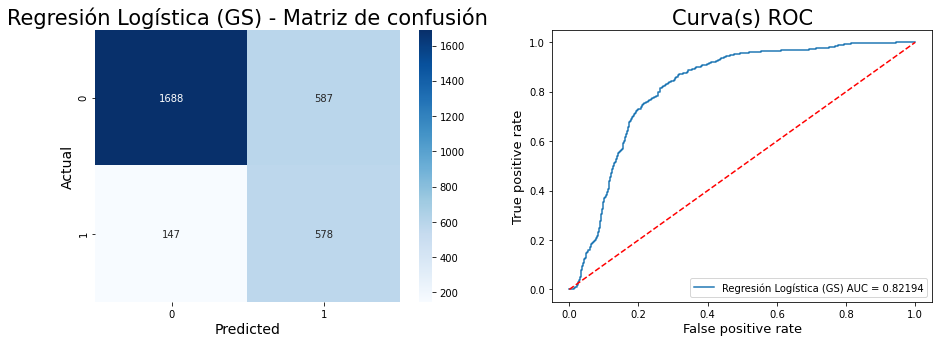

In [34]:
plot_roc_conf_matrix(y_test,X_test, lr_gs, "Regresión Logística (GS)")


In [35]:
knn_param_grid = {"kneighborsclassifier__n_neighbors": range(1, 20),
                  "kneighborsclassifier__weights": ["uniform", "distance"]}
knn_gs=pipeline_classifier(X_train,y_train,
                         KNeighborsClassifier(), knn_param_grid )

In [36]:
knn_gs.best_params_

{'kneighborsclassifier__n_neighbors': 1,
 'kneighborsclassifier__weights': 'uniform'}

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2275
           1       0.91      0.96      0.93       725

    accuracy                           0.97      3000
   macro avg       0.95      0.96      0.95      3000
weighted avg       0.97      0.97      0.97      3000



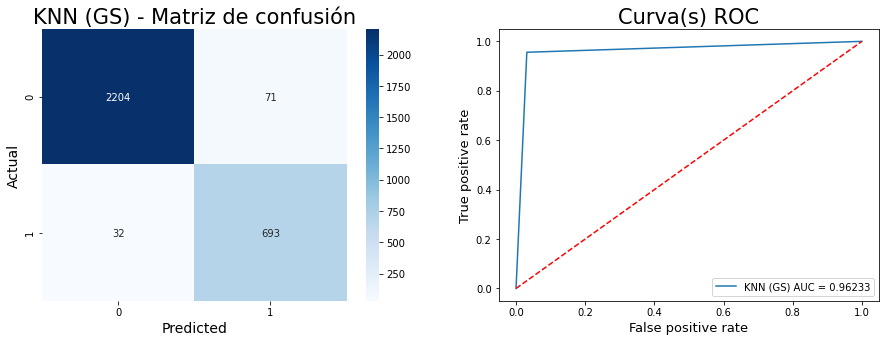

In [37]:
plot_roc_conf_matrix(y_test,X_test, knn_gs, "KNN (GS)")


In [40]:
from keras.wrappers.scikit_learn import KerasClassifier
def nn_base_model():
  nn=Sequential()
  nn.add(Dense(20, input_dim=20, activation='relu'))
  nn.add(Dropout(0.15))
  nn.add(Dense(1, activation='sigmoid'))
  nn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['binary_accuracy'])
  return nn
nn_base=KerasClassifier(build_fn=nn_base_model)

In [41]:
nn_param_grid = {"kerasclassifier__epochs": [5,10,15],
                 "kerasclassifier__batch_size": [5, 10,20]}
nn_gs=pipeline_classifier(X_train,y_train,
                         nn_base, nn_param_grid )

Epoch 1/10
3662/3662 [==============================] - 4s 1ms/step - loss: 0.4651 - binary_accuracy: 0.7740
Epoch 2/10
3662/3662 [==============================] - 4s 1ms/step - loss: 0.2296 - binary_accuracy: 0.9193
Epoch 3/10
3662/3662 [==============================] - 4s 1ms/step - loss: 0.2082 - binary_accuracy: 0.9295
Epoch 4/10
3662/3662 [==============================] - 4s 1ms/step - loss: 0.2121 - binary_accuracy: 0.9228
Epoch 5/10
3662/3662 [==============================] - 4s 1ms/step - loss: 0.2059 - binary_accuracy: 0.9294
Epoch 6/10
3662/3662 [==============================] - 4s 1ms/step - loss: 0.2027 - binary_accuracy: 0.9314
Epoch 7/10
3662/3662 [==============================] - 4s 1ms/step - loss: 0.1962 - binary_accuracy: 0.9311
Epoch 8/10
3662/3662 [==============================] - 4s 1ms/step - loss: 0.1975 - binary_accuracy: 0.9303
Epoch 9/10
3662/3662 [==============================] - 4s 1ms/step - loss: 0.1915 - binary_accuracy: 0.9352
Epoch 10/10
3662/36

In [42]:
nn_gs.best_params_

{'kerasclassifier__batch_size': 5, 'kerasclassifier__epochs': 10}

              precision    recall  f1-score   support

           0       0.97      0.94      0.96      2275
           1       0.84      0.92      0.88       725

    accuracy                           0.94      3000
   macro avg       0.90      0.93      0.92      3000
weighted avg       0.94      0.94      0.94      3000



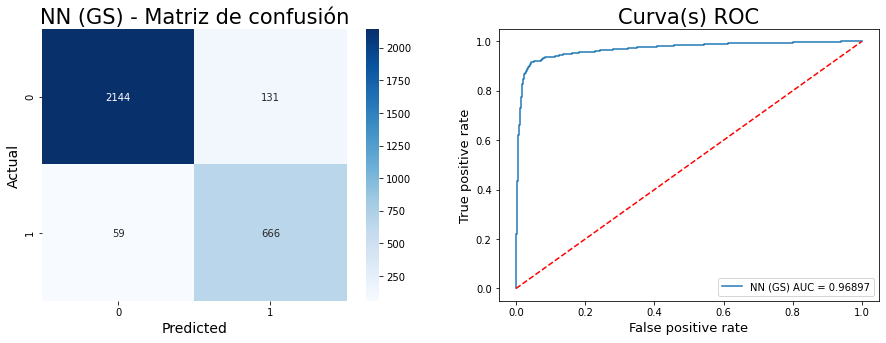

In [43]:
plot_roc_conf_matrix(y_test,X_test, nn_gs, "NN (GS)")


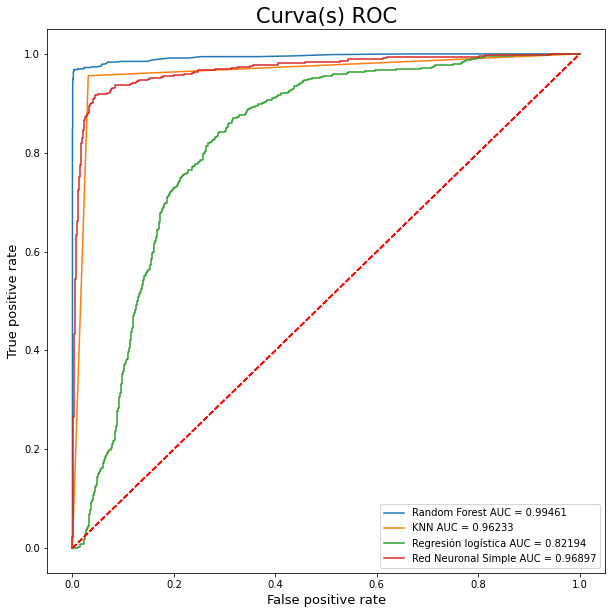

In [260]:
plt.figure(figsize=(10,10))


rocauc_plot(rf_gs, "Random Forest", y_test, X_test)
rocauc_plot(knn_gs, "KNN", y_test, X_test)
rocauc_plot(lr_gs, "Regresión logística", y_test, X_test)
rocauc_plot(nn_gs, "Red Neuronal Simple", y_test, X_test)

El mejor modelo es el Random Forest. Se procede a guardar el modelo y se simula la carga del mismo y su uso para predecir la probablidad de que un empleado abanode la organización sobre datos "reales" o no vistos (esto es, el set de pruebas que se separó antes de entrenar a los modelos)



In [46]:
import joblib

In [226]:
# Se crea una copia de la clase de nuestro pipeline de predicción
model_to_save=rf_gs
# Se agrega el atributo feature_names_
# Este es, un array con los nombres de los features
model_to_save.feature_names_=X.columns.values
# Se agrega el atributo feature_df_.
# Este es, un DataFrame con los Feature y su importancia en el modelo
imp_df=pd.DataFrame(X.T.iloc[:,1])
imp_df[1]=rf_gs.best_estimator_[1].feature_importances_
imp_df=imp_df.rename(columns = {1:'Feature Importance'})\
             .sort_values(by='Feature Importance', ascending=False)\
             .reset_index().rename(columns = {'index':'Feature'})
model_to_save.feature_df_=imp_df


In [227]:
# Se guarda el modelo
joblib.dump(model_to_save, 'clonk_rf_model.pkl')

['clonk_rf_model.pkl']

In [228]:
# Se carga el modelo
clonk_model=joblib.load("clonk_rf_model.pkl")

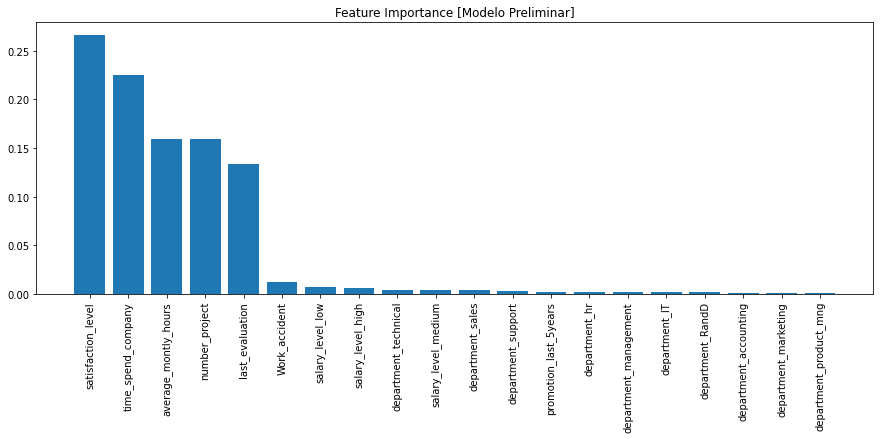

In [261]:
"""
Usando el atributo que se creó, feature_df_, se extrae un gráfico de Feature
Importance del modelo.
"""
plt.figure(figsize=(15, 5))
plt.bar(clonk_model.feature_df_['Feature'], \
        clonk_model.feature_df_['Feature Importance'])
_=plt.xticks( rotation=90)
plt.title("Feature Importance [Modelo Preliminar]");

In [295]:
"""
Usando los datos a los que no ha sido expuesto el modelo, y_test y X_test
para simular la exposición a datos a datos nunca vistos.

Se crea un dataframe a partir de estos y realizaremos la predicción
del modelo sobre estos datos y evaluaremos la calidad del modelo.

"""
model_test=X_test.copy()
model_test["employee_left (Real)"]=y_test
model_test["employee_left (Predicted_probability)"]=\
            clonk_model.predict_proba(model_test.iloc[:,:-1])[:,1]
model_test["employee_left (Predicted)"]=\
            clonk_model.predict(model_test.iloc[:,:-2])
model_test.reset_index(inplace=True)
model_test

,index,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_level_high,salary_level_low,salary_level_medium,employee_left (Real),employee_left (Predicted_probability),employee_left (Predicted)
0,814,0.10,0.92,7,253,4,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0.992,1
1,5814,0.76,0.65,4,195,3,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0.004,0
2,452,0.10,0.87,6,286,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1.000,1
3,6713,0.83,0.86,3,179,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0.004,0
4,14929,0.10,0.83,7,302,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1.000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,14961,0.73,0.97,6,189,2,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0.984,1
2996,2315,0.78,0.76,5,168,4,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0.000,0
2997,3610,0.84,0.90,3,262,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0.012,0
2998,14924,0.10,0.81,6,245,4,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0.996,1


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2275
           1       0.99      0.96      0.98       725

    accuracy                           0.99      3000
   macro avg       0.99      0.98      0.99      3000
weighted avg       0.99      0.99      0.99      3000



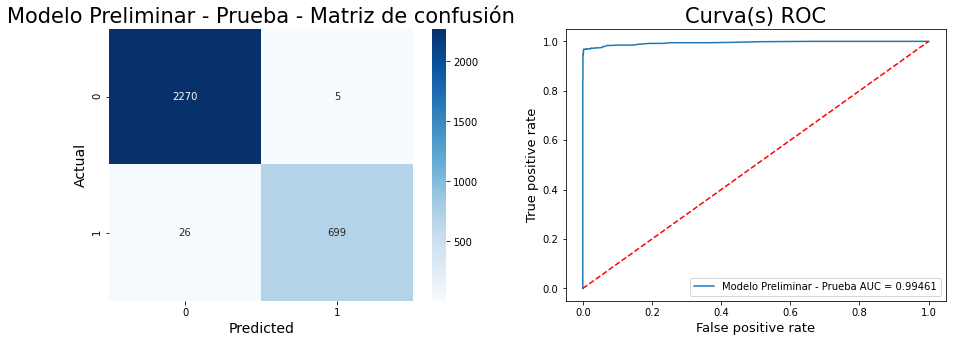

In [306]:
# Se simula la evaluación del modelo sobre datos nunca vistos.
plot_roc_conf_matrix(y_test,X_test, clonk_model, "Modelo Preliminar - Prueba")